# Importation des packages

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

# Importation des données

In [ ]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

trainY = tf.keras.utils.to_categorical(trainY, 10)
testY = tf.keras.utils.to_categorical(testY, 10)

# Entraînement normal

In [ ]:
model = Sequential([Input(shape=(28, 28, 1)),
                     Conv2D(32, (3, 3), strides=2, padding="same"),
                      LeakyReLU(alpha=0.2),
                      Conv2D(64, (3, 3), strides=2, padding="same"),
                      LeakyReLU(alpha=0.2),
                      Flatten(),
                      Dense(16),
                      Dense(10, activation='softmax')])

In [ ]:
model.compile(loss=CategoricalCrossentropy(), optimizer=SGD(lr=0.1), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                50192     
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

In [ ]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2495 - accuracy: 0.9234 - val_loss: 0.1340 - val_accuracy: 0.9605
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1030 - accuracy: 0.9688 - val_loss: 0.0839 - val_accuracy: 0.9712
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0762 - accuracy: 0.9772 - val_loss: 0.0659 - val_accuracy: 0.9783
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0636 - accuracy: 0.9801 - val_loss: 0.0595 - val_accuracy: 0.9802
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0539 - accuracy: 0.9833 - val_loss: 0.0528 - val_accuracy: 0.9834
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0466 - accuracy: 0.9852 - val_loss: 0.0564 - val_accuracy: 0.9822
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0412 - accuracy: 0.9869 - val_loss: 0.0525 - val_accuracy:

# Auto-encoder

In [ ]:
def autoencoder(width, height, depth, latentDim=16):

  # Encodeur
  inputs = Input(shape=(height, width, depth))

  x = inputs
  x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)

  volumeSize = K.int_shape(x)
  x = Flatten()(x)
  latent = Dense(latentDim)(x)

  encoder = Model(inputs, latent, name="encoder")

  # Décodeur

  latentInputs = Input(shape=(latentDim,))
  x = Dense(np.prod(volumeSize[1:]))(latentInputs)
  x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
  x = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
  outputs = Activation("sigmoid")(x)

  decoder = Model(latentInputs, outputs, name="decoder")

  # Auto-encodeur
  autoencoder = Model(inputs, decoder(encoder(inputs)),
		name="autoencoder")
 
  return (encoder, decoder, autoencoder)

In [ ]:
(encoder, decoder, autoencoder) = autoencoder(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=30,
	batch_size=32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0197 - val_loss: 0.0107
Epoch 2/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0101 - val_loss: 0.0093
Epoch 3/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 4/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 5/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 6/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 7/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 8/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 9/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.007

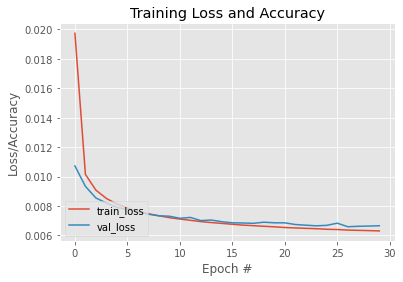

In [ ]:
N = np.arange(0, 30)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
model2 = Sequential([encoder, Dense(10, activation='softmax')])
model2.compile(loss=CategoricalCrossentropy(), optimizer=SGD(lr=0.1), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                50192     
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

In [ ]:
history2 = model2.fit(trainX, trainY, validation_data=(testX, testY), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2627 - accuracy: 0.9200 - val_loss: 0.1030 - val_accuracy: 0.9683
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0975 - accuracy: 0.9704 - val_loss: 0.0786 - val_accuracy: 0.9739
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0745 - accuracy: 0.9773 - val_loss: 0.0860 - val_accuracy: 0.9710
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0621 - accuracy: 0.9807 - val_loss: 0.0546 - val_accuracy: 0.9818
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0532 - accuracy: 0.9837 - val_loss: 0.1041 - val_accuracy: 0.9644
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0461 - accuracy: 0.9855 - val_loss: 0.0533 - val_accuracy: 0.9816
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0429 - accuracy: 0.9859 - val_loss: 0.0546 - val_accuracy: